# Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from itertools import cycle

# Load the dataset

In [27]:
df = pd.read_csv('dataset.csv')

# Separate features and labels

In [28]:
X = df.drop('tree species', axis=1).values
y = df['tree species'].values

# Encode the labels

In [29]:
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)

# Split the dataset into training and testing sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=10)

# Define the neural network model

In [31]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(15, input_dim=X_train.shape[1], activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# Create the model

In [32]:
model = create_model()

# Print the model summary

In [33]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 15)                75        
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 48        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [34]:
history = model.fit(X_train, y_train, epochs=200, batch_size=7, validation_split=0.2, verbose=0)

# Plot training & validation accuracy values

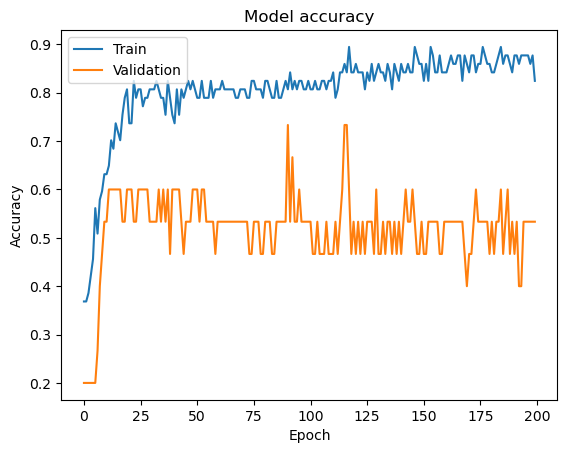

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values

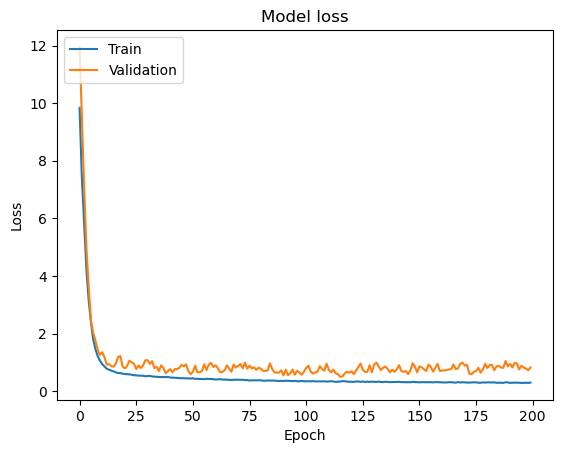

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data

In [37]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {scores[0]} / Test accuracy: {scores[1]}')


Test loss: 0.360557496547699 / Test accuracy: 0.7777777910232544


# Predict the classes on the test set

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute and plot the confusion matrix

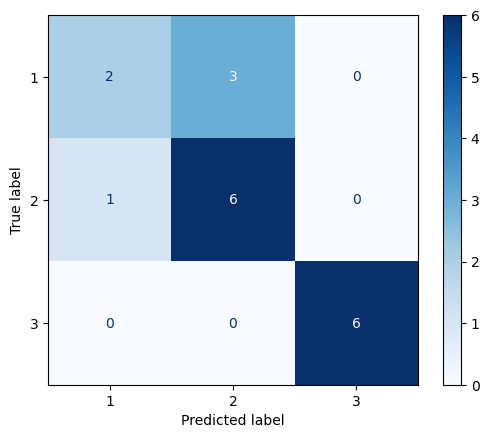

In [39]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Compute ROC curve and ROC area for each class

In [40]:
n_classes = dummy_y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area

In [41]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves

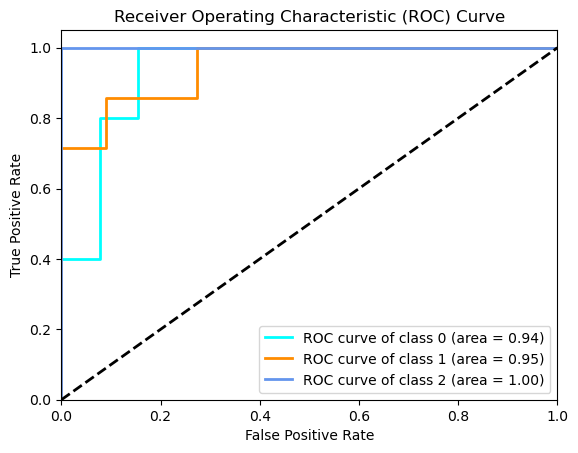

In [42]:
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Initialize K-Fold Cross Validation

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

# Lists to store scores and histories

In [44]:
all_scores = []
all_histories = []

# K-Fold Cross Validation

In [45]:
for train_index, val_index in kfold.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = dummy_y[train_index], dummy_y[val_index]
    
    model = create_model()
    history = model.fit(X_train, y_train, epochs=300, batch_size=7, validation_data=(X_val, y_val), verbose=0)
    
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    all_scores.append((val_loss, val_accuracy))
    all_histories.append(history.history)

# Calculate average scores

In [46]:
avg_val_loss = np.mean([score[0] for score in all_scores])
avg_val_accuracy = np.mean([score[1] for score in all_scores])
print(f'Average validation loss: {avg_val_loss}')
print(f'Average validation accuracy: {avg_val_accuracy}')

Average validation loss: 0.6772193014621735
Average validation accuracy: 0.6888889074325562


# Plot training & validation accuracy values for the last fold

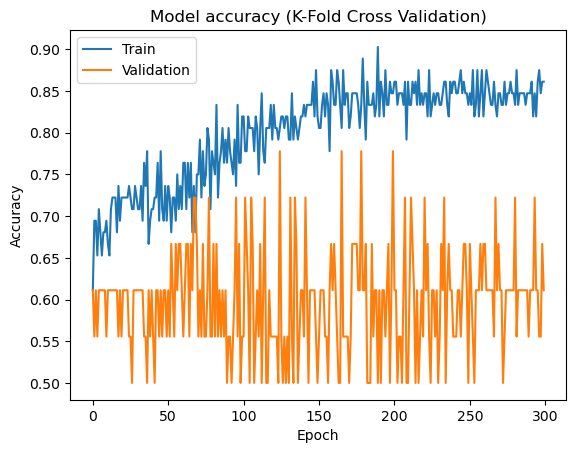

In [47]:
plt.plot(all_histories[-1]['acc'])
plt.plot(all_histories[-1]['val_acc'])
plt.title('Model accuracy (K-Fold Cross Validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values for the last fold

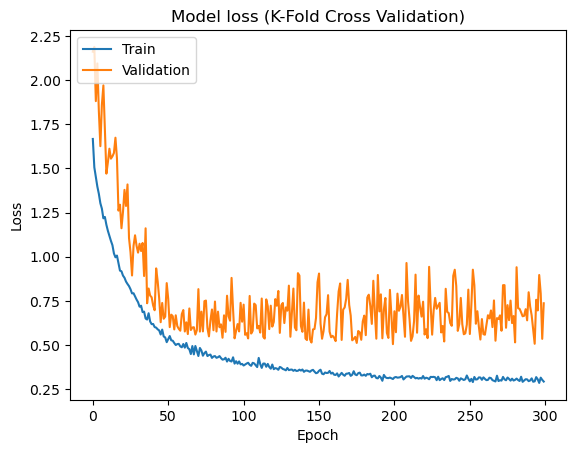

In [48]:
plt.plot(all_histories[-1]['loss'])
plt.plot(all_histories[-1]['val_loss'])
plt.title('Model loss (K-Fold Cross Validation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()